Using a ACO to learn mywayhome (test where I limit it to 4 directions)

Import everything

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
from torch.utils.tensorboard import SummaryWriter
from vizdoom import * #Import all of vizdoom
import time #To make the program sleep (wait), so we can actually see what's happening
from gymnasium import Env #Import OpenAI Gym's Env class
from gymnasium.spaces import Discrete, Box #Import OpenAI Gym's Discrete and Box spaces
import cv2 #OpenCV for image processing, used for modifying the DOOM environment to make it run faster 
from stable_baselines3.common.callbacks import BaseCallback #Import the BaseCallback class from stable_baselines3 to learn from the environment
from stable_baselines3.common import env_checker #Import the env_checker class from stable_baselines3 to check the environment
import os #To create directories for saving models
import sys #To change the path so we can import the pathfinder module
import matplotlib.pyplot as plt
from collections import deque

original_sys_path = sys.path.copy() #Come back to this path later after we navigate to the parent directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  #Add the parent directory to the path so we can import the pathfinder module
from pathfinder import doomfinder, create_new_best_generation_directory, gamefinder #Import functions from the pathfinder module
sys.path = original_sys_path #Set the path back to the original path

Create a grid with map boundries defined 

-1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 

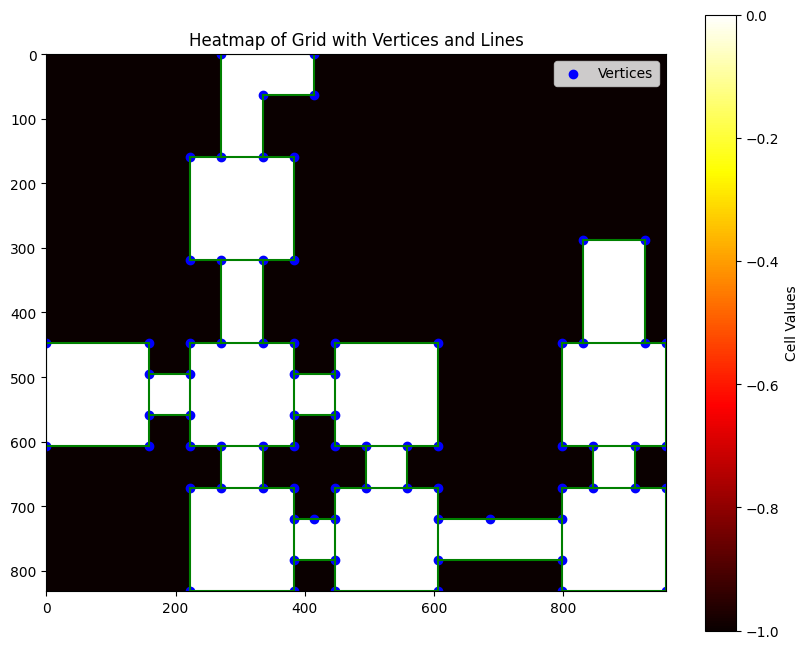

In [3]:
#Map extreme vertices
MIN_X, MAX_X = 160, 1120
MIN_Y, MAX_Y = -704, 128

#Grid dimensions, the map size is actually 960x832
GRID_WIDTH = 960  #1 unit per cell
GRID_HEIGHT = 832  #1 unit per cell

grid_size = (GRID_HEIGHT, GRID_WIDTH)

#Extracted vertices (x, y) coordinates
vertices = [
    (160.000, -256.000), (160.000, -96.000), (320.000, -96.000), (320.000, -144.000),
    (320.000, -256.000), (320.000, -208.000), (544.000, -256.000), (496.000, -256.000),
    (544.000, -96.000), (544.000, -144.000), (384.000, -96.000), (432.000, -96.000),
    (384.000, -256.000), (384.000, -208.000), (544.000, -32.000), (496.000, -32.000),
    (544.000, 128.000), (544.000, 80.000), (384.000, 128.000), (384.000, -32.000),
    (608.000, -256.000), (608.000, -208.000), (768.000, -256.000), (768.000, -96.000),
    (608.000, -96.000), (656.000, -96.000), (608.000, -32.000), (608.000, 16.000),
    (768.000, -32.000), (720.000, -32.000), (768.000, 128.000), (768.000, 80.000),
    (608.000, 128.000), (384.000, -384.000), (432.000, -384.000), (384.000, -544.000),
    (544.000, -544.000), (496.000, -544.000), (544.000, -384.000), (960.000, -32.000),
    (960.000, 16.000), (1120.000, -32.000), (1072.000, -32.000), (1120.000, 128.000),
    (960.000, 128.000), (960.000, -256.000), (960.000, -96.000), (1120.000, -256.000),
    (1088.000, -256.000), (1120.000, -96.000), (1008.000, -96.000), (992.000, -416.000),
    (992.000, -256.000), (1088.000, -416.000), (1072.000, -96.000), (1008.000, -32.000),
    (384.000, -144.000), (848.000, 16.000), (768.000, 16.000), (960.000, 80.000),
    (576.000, 16.000), (544.000, 16.000), (608.000, 80.000), (720.000, -96.000),
    (656.000, -32.000), (496.000, -96.000), (432.000, -32.000), (432.000, -256.000),
    (496.000, -384.000), (432.000, -704.000), (432.000, -544.000), (496.000, -640.000),
    (576.000, -640.000), (576.000, -704.000), (544.000, -208.000), (608.000, -144.000)
]

#Extracted linedefs as pairs of vertex indices
linedefs = [
    (0, 1), (1, 2), (2, 3), (4, 0), (5, 4), (6, 7), (8, 9), (10, 11),
    (12, 13), (14, 15), (16, 17), (18, 16), (19, 18), (20, 21), (22, 20),
    (23, 22), (24, 25), (26, 27), (28, 29), (30, 31), (32, 30), (33, 34),
    (35, 33), (36, 37), (38, 36), (39, 40), (41, 42), (43, 41), (44, 43),
    (45, 46), (47, 48), (49, 47), (46, 50), (51, 52), (53, 51), (48, 53),
    (48, 52), (13, 5), (52, 45), (54, 49), (42, 54), (42, 55), (50, 55),
    (50, 54), (13, 56), (55, 39), (57, 58), (31, 58), (31, 59), (40, 59),
    (40, 57), (58, 28), (59, 44), (60, 61), (17, 61), (17, 62), (27, 62),
    (27, 60), (61, 14), (62, 32), (29, 63), (29, 64), (25, 64), (25, 63),
    (56, 10), (63, 23), (64, 26), (15, 65), (15, 66), (11, 66), (11, 65),
    (3, 5), (65, 8), (66, 19), (67, 12), (34, 67), (34, 68), (7, 68),
    (7, 67), (3, 56), (68, 38), (69, 70), (37, 70), (37, 71), (71, 72),
    (72, 73), (73, 69), (70, 35), (21, 74), (9, 74), (9, 75), (21, 75),
    (75, 24), (74, 6)
]

#Initialize the grid with -1 (outside cells)
starter_grid = np.full(grid_size, -1, dtype=np.float64)

def coord_to_grid(x, y):
    #Convert coordinates to grid indices
    if x < MIN_X or x > MAX_X or y < MIN_Y or y > MAX_Y:
        raise ValueError(f"Coordinates ({x}, {y}) are out of bounds!")
    
    norm_x = (x - MIN_X) / (MAX_X - MIN_X)
    norm_y = (y - MIN_Y) / (MAX_Y - MIN_Y)
    
    grid_x = int(norm_x * (GRID_WIDTH - 1))
    grid_y = int(norm_y * (GRID_HEIGHT - 1))

    return (grid_x, grid_y)

def draw_line(starter_grid, start, end):
    x1, y1 = coord_to_grid(start[0], start[1])
    x2, y2 = coord_to_grid(end[0], end[1])
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        starter_grid[y1, x1] = 0  # Mark cell as 0 (inside the linedef)
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy


#Draw all lines on the grid
for linedef in linedefs:
    start_vertex = vertices[linedef[0]]
    end_vertex = vertices[linedef[1]]
    draw_line(starter_grid, start_vertex, end_vertex)


#Function to print the grid
def print_grid(starter_grid):
    for row in starter_grid:
        print(' '.join(f'{cell:3}' for cell in row))

#Print the grid to check the result
print_grid(starter_grid)


def flood_fill(starter_grid, start_x, start_y):
    if starter_grid[start_y, start_x] != -1:  # Start only if the cell is not filled or part of the boundary
        return

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    queue = deque([(start_x, start_y)])

    while queue:
        x, y = queue.popleft()

        if starter_grid[y, x] != -1:  # If already visited or is a boundary, skip
            continue

        starter_grid[y, x] = 0  # Fill the cell

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_WIDTH and 0 <= ny < GRID_HEIGHT and starter_grid[ny, nx] == -1:
                queue.append((nx, ny))


insides = [(385, -144), (319, -208), (321, -207), (545, -207), (654, -97), (496, -641), (432, -543), (464, -320), (461, 49), (464, -68),
           (578, 48), (672, -64), (832, 64), (672, 64), (1056, -288), (1024, -160), (1056, -65), (1024, 32)]

for vertex in insides:
    x, y = coord_to_grid(vertex[0], vertex[1])
    flood_fill(starter_grid, x, y)
       

#Plot vertices
plt.figure(figsize=(10, 8))
plt.scatter(*zip(*[coord_to_grid(v[0], v[1]) for v in vertices]), c='blue', label='Vertices')

#Plot lines
for linedef in linedefs:
    start_vertex = vertices[linedef[0]]
    end_vertex = vertices[linedef[1]]
    start_grid = coord_to_grid(start_vertex[0], start_vertex[1])
    end_grid = coord_to_grid(end_vertex[0], end_vertex[1])
    plt.plot([start_grid[0], end_grid[0]], [start_grid[1], end_grid[1]], c='green')

#Create a heatmap to visualize the grid
plt.imshow(starter_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='Cell Values')
plt.title('Heatmap of Grid with Vertices and Lines')
plt.legend()
plt.show()

def get_starting_grid():
    starter_grid = np.full(grid_size, -1, dtype=np.float64)
    for linedef in linedefs:
        start_vertex = vertices[linedef[0]]
        end_vertex = vertices[linedef[1]]
        draw_line(starter_grid, start_vertex, end_vertex)
    for vertex in insides:
        x, y = coord_to_grid(vertex[0], vertex[1])
        flood_fill(starter_grid, x, y)
    return starter_grid

Define enviornment (for mywayhome)

In [4]:
#Note we are using are representing the map as a 960x832 grid

#Map extreme verticies
MIN_X, MAX_X = 160, 1120
MIN_Y, MAX_Y = -704, 128

#Grid dimensions, the map size is actually 960x832 but this allows us some leeway if we get close to the edge
GRID_WIDTH = 960 #1 unit per cell
GRID_HEIGHT = 832 #1 units per cell

starter_grid = get_starting_grid()

class mywayhome_VZG(Env): #Used for mywayhome config
    def __init__(self, config_path, render=False, grid_size=(GRID_HEIGHT, GRID_WIDTH), pheromone_evaporation_rate=0.001, pheromone_map = None, frameskip = 1): #Constructor
        #Args:
            #config_path (str): The path to the configuration file
            #render (bool): Whether to render the environment or not, false by default
            #grid_size (tuple): The size of the grid (x, y) for the environment
            #pheromone_evaporation_rate (float): The rate at which pheromones evaporate over time
            #pheromone_map (np.array): Optional pre-filled pheromone map, if not provided, it will be initialized with low pheromone levels
            #frameskip (int): The number of frames to skip between actions

        super(mywayhome_VZG, self).__init__() #Inherit from Env class

        #Setup game environment
        self.game = vizdoom.DoomGame() #Create a DoomGame object
        self.game.set_doom_game_path(gamefinder('DOOM2.WAD')) #Set the path to the game
        self.game.load_config(config_path) #Load the configuration file from file path
        self.game.set_window_visible(render) #Set window visibility based on render argument
        self.game.init() #Initialize the game
        self.frameskip = frameskip #Set the frameskip
        
        #Setup action and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8) #Observation space, 100x160x1 image
        self.action_space = Discrete(4) #Action space, 4 actions (move forward, move left, move right, move backwards)

        #Grid dimensions and pheromone setup
        self.grid_size = grid_size #Set the grid size as specified 
        if pheromone_map is not None:
            self.pheromone_map = pheromone_map #Use the provided pheromone map if available
        else: #If no pheromone map is provided, initialize a new one
            self.pheromone_map = starter_grid  #Start with adjustable pheromone levels across the gri
        self.pheromone_evaporation_rate = pheromone_evaporation_rate  #Controls how fast pheromones decay over time

        #Get game variables
        game_variables = self.game.get_state().game_variables
        xpos, ypos, angle = game_variables #Unpack the game variables
        
        self.xpos = xpos #X position of the player
        self.ypos = ypos #Y position of the player
        self.angle = angle #Angle of the player 

    def coord_to_grid(self, x, y): #Convert coordinates to grid indices
        #Args:
            #x (int): X coordinate to convert
            #y (int): Y coordinate to convert
        #Returns:
            #grid_x, grid_y (tuple): The grid indices corresponding to the coordinates
        #Raises:
            #ValueError: If the coordinates are out of bounds

        #Ensure coordinates are within world bounds
        if x < MIN_X or x > MAX_X or y < MIN_Y or y > MAX_Y:
            raise ValueError(f"Coordinates ({x}, {y}) are out of bounds!")
        
        #Normalize coordinates to range [0, 1]
        norm_x = (x - MIN_X) / (MAX_X - MIN_X)
        norm_y = (y - MIN_Y) / (MAX_Y - MIN_Y)
        
        #print(f"norm_x = {norm_x}, norm_y = {norm_y}") #Debug print

        #Scale to grid dimensions and floor the values to ensure integers
        grid_x = int(norm_x * (GRID_WIDTH - 1))
        grid_y = int(norm_y * (GRID_HEIGHT - 1))

        #print(f"grid_x = {grid_x}, grid_y = {grid_y}") #Debug print

        return (grid_x, grid_y)

    def step(self, action, limit = 1000): #Take a step in the environment 
        #Args:
            #action (int): The action to take
            #limit (int): Unimplemented "limit" for the episode, most likely will be a time limit
        #Returns:
            #observation (np.array): The screen buffer of the environment
            #reward (float): The reward for the action taken
            #terminated (bool) Whether the episode is finished or not (by reaching the goal)
            #truncated (bool): Whether the episode has reached some terminal state without reaching the goal (ie: running out of time)
            #info (dict): Additional information about the environment

        #print(f"xpos = {self.xpos}, ypos = {self.ypos}, angle = {self.angle}") #Debug print

        #Specify actions and take a step
        actions = np.identity(4) #Create an identity matrix with 4 rows (4 actions), TURN_LEFT, TURN_RIGHT, MOVE_FOWARD, MOVE_LEFT, MOVE_RIGHT, MOVE_BACKWARD, these are the actions we can take in the environment
            
        self.game.make_action(actions[action], self.frameskip) #Take an action in the action space, second parameter is frame skip (how many frames we take an action for)
        truncated = False #Not implemented yet, so set to False. The idea is that if step passes some sort of limit, like a time limit, then the episode is truncated.
        info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle} # Initialize info with current position and angle
        reward = 0 #Initialize reward to 0

        if self.game.get_state(): #If the game is not finished
            observation = self.game.get_state().screen_buffer #Get the screen buffer
            observation = self.greyscale(observation) #Convert the image to greyscale
            
            xpos, ypos, angle = self.game.get_state().game_variables #Get the game variables
            self.xpos = xpos #Update the x position
            self.ypos = ypos #Update the y position
            self.angle = angle #Update the angle

            info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle} #Add position and angle to the info dictionary
            (grid_x, grid_y) = self.coord_to_grid(xpos, ypos) #Find the grid indices of the current position

        #Update pheromones based on movement feedback
            #If this isnt a wall, add pheromones
            #self.pheromone_map[grid_y, grid_x] += 0.1 #Deposit pheromones
            #self.pheromone_map[self.pheromone_map != -1] *= (1 - self.pheromone_evaporation_rate)  #Simulate evaporation, except on walls
        else: #If the game is finished
            observation = np.zeros(self.observation_space.shape) #Return a blank screen

        terminated = self.game.is_episode_finished() #Check if the episode is finished

        return observation, reward, terminated, truncated, info

    def reset(self): #Reset the environment when we start a new game
        #Args:
            #seed (int): The seed for the random number generator
        #Returns:
            #(observation, info) (tuple)
                #observation (np.array): The screen buffer of the environment
                #info (dict): Additional information about the environment
                
        self.game.new_episode() #Start a new episode
        game_variables = self.game.get_state().game_variables  #Get the game variables   
        self.xpos, self.ypos, self.angle = game_variables  #Unpack the game variables, set agent to its random starting position 

        state = self.game.get_state().screen_buffer
        observation = self.greyscale(state)  #Convert the initial screen state to greyscale
        info = {"xpos": self.xpos, "ypos": self.ypos, "angle": self.angle} #Add position and angle to the info dictionary

        return observation, info  #Return the observation and any additional info

    def greyscale(self, observation): #Convert the environment image to greyscale and resize it
        #Args:
            #observation (np.array): The image of the environment (the current game frame)
        #Returns:
            #grey_return (np.array): The resized greyscale image of the environment
        
        grey = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY) #Convert the image to greyscale
        resize = cv2.resize(grey, (160, 100), interpolation=cv2.INTER_CUBIC) #Resize the image to 160x100 (frame size)
        state = np.reshape(resize, (100, 160, 1)) #Reshape to 100x160x1 for compatibility with neural networks
        
        return state

    def render(self, render_in_greyscale=False): #Render the environment for a frame
        #Args:
            #render_in_greyscale (bool): Whether to render the environment in greyscale or not
        
        if self.game.get_state() and render_in_greyscale:  #Only render if there's a valid game state
            observation = self.game.get_state().screen_buffer
            greyscale_obs = self.greyscale(observation)  #Convert the observation to greyscale
            cv2.imshow("VizDoom Environment", greyscale_obs.squeeze())  #Remove extra dimension and display
            cv2.waitKey(1)  #Wait 1ms between frames to allow for rendering
        elif self.game.get_state():  #Only render if there's a valid game state
            observation = self.game.get_state().screen_buffer
            cv2.imshow("VizDoom Environment", observation.squeeze())  #Render the environment without greyscale
            cv2.waitKey(1)  #Wait 1ms between frames to allow for rendering
        else:
            print("No game state to render.")

    def get_state(self): #Get the current state of the environment
        #Returns:
            #state (np.array): The current state of the environment
        return self.game.get_state()

    def get_agent_position(self): #Get the current position of the agent (tuple of x, y coordinates)
        #Returns:
            #(xpos, ypos) (tuple): The current position of the agent

        return (self.xpos, self.ypos)

    def close(self): #Close the environment when done
        self.game.close()  #Terminate the game

Define Plotting, Saving, and Finding Pheromone Maps

In [5]:
import matplotlib.colors as mcolors

def plot_pheromone_grid(pheromone_grid, title, log_dir, iteration, save_image):
    #Create a custom colormap
    cmap = plt.cm.hot
    cmap = cmap.copy()
    cmap.set_bad(color='blue') #Set color for walls (-1) to black

    #Mask the grid to handle walls (-1)
    masked_grid = np.ma.masked_where(pheromone_grid == -1, pheromone_grid)

    plt.imshow(masked_grid, cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.colorbar(label="Pheromone Intensity")
    if save_image:
        image_path = os.path.join(log_dir, f"pheromone_grid_iteration_{iteration}.png")
        plt.savefig(image_path)
        print(f"Pheromone grid image saved to {image_path}")
    plt.show()


def create_run_directory(base_dir="aco_runs/vizdoom_aco_mywayhome"): #Create a new run directory for the ACO algorithm
    os.makedirs(base_dir, exist_ok=True)
    existing_runs = [int(d.split('_')[-1]) for d in os.listdir(base_dir) if d.split('_')[-1].isdigit()]
    run_number = max(existing_runs, default=0) + 1
    run_dir = os.path.join(base_dir, f"run_{run_number}")
    os.makedirs(run_dir, exist_ok=True)
    #Create saved maps directory within the run directory
    maps_dir = os.path.join(run_dir, "saved_maps")
    os.makedirs(maps_dir, exist_ok=True)
    #Create log directory within the run directory
    log_dir = os.path.join(run_dir, "log")
    os.makedirs(log_dir, exist_ok=True)
    return run_dir, log_dir, maps_dir

def save_pheromone_grid(pheromone_grid, maps_dir, iteration):
    filename = os.path.join(maps_dir, f"pheromone_grid_iteration_{iteration}.npy")
    np.save(filename, pheromone_grid)
    #print(f"Pheromone grid saved to {filename}")

def load_pheromone_grid(run_dir="aco_runs/vizdoom_aco_mywayhome", run_number=0, filename="pheromone_grid.npy"):
    run_dir = os.path.join(run_dir, f"run_{run_number}/saved_maps")
    filepath = os.path.join(run_dir, filename)
    #print(filepath) #Print the path
    if os.path.exists(filepath):
        pheromone_grid = np.load(filepath)
        #print(f"Pheromone grid loaded from {filepath}")
        return pheromone_grid
    else:
        #print(f"No saved pheromone grid found at {filepath}")
        return None

Define Training

In [38]:
def aco_training(env, num_ants=10, iterations=50, alpha=0.6, beta=0.4, pheromone_deposit=2.0, unsucessful_deposit=0.1, run_dir="aco_runs/vizdoom_aco_mywayhome", log_dir = "aco_runs/vizdoom_aco_mywayhome/run_x/log", maps_dir = "aco_runs/vizdoom_aco_mywayhome/run_x/saved_maps", distance_weight = 0.7, time_weight = 0.3, evaporation_rate = 1.0): #Train the ACO algorithm in the ViZDoom environment
    """
    Train a bot to pathfind in the ViZDoom environment using ACO.
    
    Args:
        env (Env): The ViZDoom environment.
        num_ants (int): Number of ants (pathfinding agents) per iteration.
        iterations (int): Total iterations for ACO.
        alpha (float): Importance of pheromones.
        beta (float): Importance of heuristic (distance to goal).
        pheromone_deposit (float): Amount of pheromone deposited on successful paths.
        unsucessful_deposit (float): Amount of pheromone deposited on unsuccessful paths.
        run_dir (str): Directory to save the ACO run data.
        log_dir (str): Directory to save logs and images.
        maps_dir (str): Directory to save pheromone maps.
        distance_weight (float): Weight for distance factor in pheromone update.
        time_weight (float): Weight for time factor in pheromone update.
        evaporation_rate (float): Rate of pheromone evaporation.
    """
    #Initialize pheromone grid
    pheromone_grid = env.pheromone_map
    
    frameskip = env.frameskip #Get the frameskip from the environment

    #Normalize alpha and beta to ensure they add up to 1
    total_weight = alpha + beta
    alpha /= total_weight
    beta /= total_weight

    #Generate list of goal positions
    #GOAL_POSITIONS = [env.coord_to_grid(x, y) for x in range(1008, 1072) for y in range(-324, -315)] 

    GOAL_POSITION = (1045, -316) #We simplify from a list of goal positions to one goal position because 
    #having a list of goal positions causes the agent to get stuck in a loop where it keeps going back and forth 
    #between the goal positions different equal minimum distances, which weakens the hueristic function, this 
    #position will always trigger the end of the episode

    #Heuristic function: inverse distance to the goal
    def heuristic(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        return 1.0 / (distance + 1e-6)

    #Simulate movement locally without stepping the game
    def simulate_move(x, y, move):
        #print(f"x passed is {x}, y passed is {y}")  #Debug print

        step_size = 1  #Approximate movement step size; tune based on game behavior

        if move == 0:  #MOVE_FORWARD
            return x + step_size, y + step_size
        elif move == 1:  #MOVE_LEFT
            return x - step_size, y + step_size
        elif move == 2:  #MOVE_RIGHT
            return x + step_size, y - step_size
        elif move == 3:  #MOVE_BACKWARD
            return x - step_size, y - step_size 
        return x, y

    #Function to select next move based on pheromones and heuristic
    def select_next_move(x, y):
        possible_moves = [0, 1, 2, 3]  #TURN_LEFT, TURN_RIGHT, etc.
        probs = []
        backup_probs = [] #Saves probabilities incase all moves have already been taken
        valid_moves = [] #List of valid moves
        pheromone_values = [] #List of pheromone values in the possible moves
        eta_values = [] #List of heuristic values in the possible moves
        distances = [] #List of distances to the goal for each move

        for move in possible_moves:
            #Simulate movement locally without stepping the game
            simulated_x, simulated_y = simulate_move(x, y, move)
            #print(f"Simulated move: {move}, x: {simulated_x}, y: {simulated_y}, angle: {simulated_angle}")  #Debug print

            #Convert to grid indices and calculate pheromone + heuristic
            grid_x, grid_y = env.coord_to_grid(simulated_x, simulated_y)
            if 0 <= grid_x < GRID_WIDTH and 0 <= grid_y < GRID_HEIGHT:
                pheromone = pheromone_grid[grid_y, grid_x]
                if pheromone > 0: #If the move is not a wall
                    eta = heuristic(grid_x, grid_y)
                    distance = np.sqrt((GOAL_POSITION[0] - grid_x) ** 2 + (GOAL_POSITION[1] - grid_y) ** 2)
                    #print(f"eta = {eta}, pheromone = {pheromone}")
                    pheromone_values.append(pheromone)
                    eta_values.append(eta)
                    distances.append(distance)
                    valid_moves.append((move, grid_x, grid_y)) #Add the move to the list of valid moves

        if not valid_moves:
            #print("No valid moves available. Selecting a random move.")
            return np.random.choice(possible_moves)

        max_pheromone = np.max(pheromone_values) #Get the maximum pheromone level
        max_eta = np.max(eta_values) #Get the maximum eta value

        #Rank the moves based on distance to the goal
        sorted_indices = np.argsort(distances)
        valid_moves = [valid_moves[i] for i in sorted_indices]
        rank_boosts = np.zeros(len(valid_moves))
        boost_values = [1.0, 0.5, 0.25, 0.0]  #The move closest to the goal gets the highest boost, the farthest gets the lowest
        moves_considered = []

        rank = 0 #Start at rank 0
        for i in range(len(sorted_indices)): #Iterate through the sorted indices
            if i > 0 and distances[sorted_indices[i]] != distances[sorted_indices[i-1]]: #If the distance is different from the previous distance
                rank += 1 #Increment the rank 
            if rank < len(boost_values): #If the rank is less than the number of boost values
                rank_boosts[sorted_indices[i]] = boost_values[rank] #Set the rank boost value
            else:
                rank_boosts[sorted_indices[i]] = 0.0 #Otherwise, set the rank boost to 0

        for i, (move, grid_x, grid_y) in enumerate(valid_moves):
            pheromone = pheromone_grid[grid_y, grid_x]
            eta = heuristic(grid_x, grid_y)
            #Normalize pheromone and heuristic values
            norm_pheromone = pheromone / max_pheromone
            norm_eta = eta / max_eta  
            prob = (norm_pheromone ** alpha) * (norm_eta ** (beta * (1 + rank_boosts[i]))) #Boost the probability based on rank
            if (grid_x, grid_y) in path:
                probs.append(0)  #Set probability to zero if the move has already been made
                backup_probs.append(prob) 
            else:
                probs.append(prob)
                backup_probs.append(prob)
                moves_considered.append((move, grid_x, grid_y)) #Add the move to the list of moves considered
            #print(f"Move: {move}, pheromone: {pheromone}, eta: {eta}, norm_pheromone: {norm_pheromone}, norm_eta: {norm_eta}")

        #Normalize probabilities
        probs = np.array(probs)
        backup_probs = np.array(backup_probs)
        
        if probs.sum() == 0 and backup_probs.sum() == 0:
            probs = np.ones(len(valid_moves)) / len(valid_moves)  #Equal probability
        elif probs.sum() == 0: #If all possible moves have been made
            probs = backup_probs / backup_probs.sum()
        else:
            probs /= probs.sum()

        choice = np.random.choice([move for move, _, _ in valid_moves], p=probs)

        return choice
    
    #Define boundaries for classifying spawn locations
    def classify_spawn(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        #print(f"Distance to goal: {distance}")
        if distance > 600:  # Example threshold for "far"
            return "far"
        elif distance > 400:  #Spawned in the middle of the map
            return "relatively close"
        else:  
            return "close" #Spawned in the corder facing the goal


    #Main ACO loop
    
    plot_pheromone_grid(pheromone_grid, "Initial Grid", log_dir, 0, save_image=False) #Plot the pheromone grid after each ant

    #Open the file to save the success counts
    success_file_path = os.path.join(run_dir, "success_counts.txt")
    with open(success_file_path, "w") as success_file:
        for iteration in range(iterations):
            print(f"Iteration {iteration + 1}/{iterations}")

            #Initialize counters for successful ants and spawn counts
            success_counts = {
                "far": 0,
                "relatively close": 0,
                "close": 0
            }
            spawn_counts = {
                "far": 0,
                "relatively close": 0,
                "close": 0
            }

            for ant in range(num_ants):
                
                terminated = False
                tics = 10 #Start at 10 tics

                observation, info = env.reset()
                x, y, angle = env.xpos, env.ypos, env.angle
                path = []
                success = False
                spawn_classification = classify_spawn(x, y) #We spawned in this area
                spawn_counts[spawn_classification] += 1  #Increment the spawn counter

                #Calculate initial distance to the closest goal
                gx, gy = GOAL_POSITION
                initial_distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)

                while not terminated:  #Steps are limited to number of tics (2100) by the config
                    action = select_next_move(x, y)
                    observation, _, terminated, _, info = env.step(action)
                    x, y, angle = info['xpos'], info['ypos'], info['angle']
                    path.append((env.coord_to_grid(x, y)))

                    tics = tics + 1 * frameskip #Increment tics, multiply by frameskip to account for the frameskip
                
                if tics < 2100: #If the ant reached the goal
                    print(f"Ant {ant} reached the goal in {tics} steps.")
                    success = True
                    success_counts[spawn_classification] += 1 

                #Update pheromones
                if success:
                    for (px, py) in path: #Give a little boost to path if the ant reached the goal
                        distance_factor = initial_distance / (np.sqrt((px - x) ** 2 + (py - y) ** 2) + 1e-6)
                        time_factor = 1.0 / (tics + 1e-6)  #Inverse of the number of tics taken
                        combined_weight = distance_factor * distance_weight + time_factor * time_weight  #Prioritize distance factor
                        pheromone_grid[py, px] += pheromone_deposit * combined_weight
                        #print(combined_weight)
                else:
                    for (px, py) in path:
                        pheromone_grid[py, px] += unsucessful_deposit #Deposit pheromones for the path taken

                #Evaporate pheromones
                pheromone_grid[pheromone_grid != -1] *= (1 - evaporation_rate)

                print(f"Ant {iteration}.{ant}, tics: {tics}, success: {success}")
                print(f"Path: {path}")
                plot_pheromone_grid(pheromone_grid, (f"Pheromone Grid After Ant {iteration}.{ant}"), log_dir, iteration, save_image=False) #Plot the pheromone grid after each ant
            
            if(iteration % 5 == 0 and iteration < iterations): #Save the pheromone grid after every 5 iterations
                plot_pheromone_grid(pheromone_grid, (f"Iteration {iteration}"), log_dir, iteration, save_image=True)  #Save the image after every 10 iterations
            else: 
                plot_pheromone_grid(pheromone_grid, (f"Iteration {iteration}"), log_dir, iteration, save_image=False)  #Plot the pheromone grid after each iteration
            save_pheromone_grid(pheromone_grid, maps_dir, iteration)  #Save the pheromone grid at the end of iteration
        
        #Print the spawn counts and success ratios
            print("Spawn counts and success ratios:")
            for classification, count in spawn_counts.items():
                print(f"Spawned {classification}: {success_counts[classification]}/{count}")   
                success_file.write(f"Spawned {classification}: {success_counts[classification]}/{count}\n")   

    plot_pheromone_grid(pheromone_grid, (f"Final Map (Iteration {iterations})"), log_dir, iteration, save_image=True)  #Plot/save the final pheromone grid
    env.close()

Enviornment to Test Maps Trained

In [32]:
def test_saved_maps(env, num_tests=5, alpha = 0.6, beta = 0.4, pheromone_grid=None):
    """
    Test the saved pheromone maps in the ViZDoom environment.
    
    Args:
        env (Env): The ViZDoom environment.
        num_tests (int): Number of test runs to perform.
        alpha (float): Importance of pheromones.
        beta (float): Importance of heuristic (distance to goal).
        pheromone_grid (np.array): The saved pheromone grid to test.
    """
    #Load the saved pheromone grid
    if pheromone_grid is None:
        print("No saved pheromone grid found.")
        return
    
    env.pheromone_map = pheromone_grid
    
    #Normalize alpha and beta to ensure they add up to 1
    total_weight = alpha + beta
    alpha /= total_weight
    beta /= total_weight

    #Generate list of goal positions
    #GOAL_POSITIONS = [env.coord_to_grid(x, y) for x in range(1008, 1072) for y in range(-324, -315)] 

    GOAL_POSITION = (1045, -316) #We simplify from a list of goal positions to one goal position because 
    #having a list of goal positions causes the agent to get stuck in a loop where it keeps going back and forth 
    #between the goal positions different equal minimum distances, which weakens the hueristic function, this 
    #position will always trigger the end of the episode

    #Heuristic function: inverse distance to the goal
    def heuristic(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        return 1.0 / (distance + 1e-6)
    
    #Simulate movement locally without stepping the game
    def simulate_move(x, y, move):
        #print(f"x passed is {x}, y passed is {y}")  #Debug print

        step_size = 1  #Approximate movement step size; tune based on game behavior

        if move == 0:  #MOVE_FORWARD
            return x + step_size, y + step_size
        elif move == 1:  #MOVE_LEFT
            return x - step_size, y + step_size
        elif move == 2:  #MOVE_RIGHT
            return x + step_size, y - step_size
        elif move == 3:  #MOVE_BACKWARD
            return x - step_size, y - step_size 
        return x, y

    #Function to select next move based on pheromones and heuristic
    def select_next_move(x, y):
        possible_moves = [0, 1, 2, 3]  #TURN_LEFT, TURN_RIGHT, etc.
        probs = []
        backup_probs = [] #Saves probabilities incase all moves have already been taken
        valid_moves = [] #List of valid moves
        pheromone_values = [] #List of pheromone values in the possible moves
        eta_values = [] #List of heuristic values in the possible moves
        distances = [] #List of distances to the goal for each move
         
        for move in possible_moves:
            #Simulate movement locally without stepping the game
            #walls_detected = []
            simulated_x, simulated_y = simulate_move(x, y, move)
            #print(f"Simulated move: {move}, x: {simulated_x}, y: {simulated_y}, angle: {simulated_angle}")  #Debug print

            #Convert to grid indices and calculate pheromone + heuristic
            grid_x, grid_y = env.coord_to_grid(simulated_x, simulated_y)
            if 0 <= grid_x < GRID_WIDTH and 0 <= grid_y < GRID_HEIGHT:
                pheromone = pheromone_grid[grid_y, grid_x]
                if pheromone > 0: #If the move is not a wall
                    eta = heuristic(grid_x, grid_y)
                    distance = np.sqrt((GOAL_POSITION[0] - grid_x) ** 2 + (GOAL_POSITION[1] - grid_y) ** 2)
                    #print(f"eta = {eta}, pheromone = {pheromone}")
                    pheromone_values.append(pheromone)
                    eta_values.append(eta)
                    distances.append(distance)
                    valid_moves.append((move, grid_x, grid_y)) #Add the move to the list of valid moves
                #else:
                    #print(f"Wall detected, so I wont move to {env.coord_to_grid(simulated_x, simulated_y)}")  #Debug print
                    #walls_detected.append(move)

        if not valid_moves:
            #print("No valid moves available. Selecting a random move.")
            return np.random.choice(possible_moves)

        max_pheromone = np.max(pheromone_values) #Get the maximum pheromone level
        max_eta = np.max(eta_values) #Get the maximum eta value

        #Rank the moves based on distance to the goal
        sorted_indices = np.argsort(distances)
        valid_moves = [valid_moves[i] for i in sorted_indices]
        rank_boosts = np.zeros(len(valid_moves))
        boost_values = [1.0, 0.5, 0.25, 0.0]  #The move closest to the goal gets the highest boost, the farthest gets the lowest
        moves_considered = []

        #print(f"Sorted indices: {sorted_indices}")
        #print(f"Valid moves: {valid_moves}") #Debug print, check to see if the moves are sorted correctly

        rank = 0 #Start at rank 0
        for i in range(len(sorted_indices)): #Iterate through the sorted indices
            if i > 0 and distances[sorted_indices[i]] != distances[sorted_indices[i-1]]: #If the distance is different from the previous distance
                rank += 1 #Increment the rank 
            if rank < len(boost_values): #If the rank is less than the number of boost values
                rank_boosts[sorted_indices[i]] = boost_values[rank] #Set the rank boost value
            else:
                rank_boosts[sorted_indices[i]] = 0.0 #Otherwise, set the rank boost to 0

        for i, (move, grid_x, grid_y) in enumerate(valid_moves):
            pheromone = pheromone_grid[grid_y, grid_x]
            eta = heuristic(grid_x, grid_y)
            #Normalize pheromone and heuristic values
            norm_pheromone = pheromone / max_pheromone
            norm_eta = eta / max_eta  
            prob = (norm_pheromone ** alpha) * (norm_eta ** (beta * (1 + rank_boosts[i]))) #Boost the probability based on rank
            if (grid_x, grid_y) in path:
                probs.append(0)  #Set probability to zero if the move has already been made
                backup_probs.append(prob) 
            else:
                probs.append(prob)
                backup_probs.append(prob)
                moves_considered.append((move, grid_x, grid_y)) #Add the move to the list of moves considered
            #print(f"Move: {move}, pheromone: {pheromone}, eta: {eta}, norm_pheromone: {norm_pheromone}, norm_eta: {norm_eta}")

        #Normalize probabilities
        probs = np.array(probs)
        backup_probs = np.array(backup_probs)
        
        if probs.sum() == 0 and backup_probs.sum() == 0:
            probs = np.ones(len(valid_moves)) / len(valid_moves)  #Equal probability
        elif probs.sum() == 0: #If all possible moves have been made
            probs = backup_probs / backup_probs.sum()
        else:
            probs /= probs.sum()

        choice = np.random.choice([move for move, _, _ in valid_moves], p=probs)

        #print(f"Moves considered: {moves_considered}")
        #print(f"Choice made: {choice}")

        #This seems to not happen ever so thats good
        #if choice in walls_detected:
            #print("I ran into a wall for some reason.")
            #time.sleep(2) #Sleep for 2 seconds, so we can see what happened


        return choice

    #Define boundaries for classifying spawn locations
    def classify_spawn(x, y):
        gx, gy = GOAL_POSITION
        distance = np.sqrt((gx - x) ** 2 + (gy - y) ** 2)
        #print(f"Distance to goal: {distance}")
        if distance > 600:  # Example threshold for "far"
            return "far"
        elif distance > 400:  #Spawned in the middle of the map
            return "relatively close"
        else:  
            return "close" #Spawned in the corder facing the goal
 
    #Initialize counters for successful ants and spawn counts
    success_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }
    spawn_counts = {
        "far": 0,
        "relatively close": 0,
        "close": 0
    }

    #Run test episodes
    for test in range(num_tests):
        terminated = False
        tics = 10  #Start at 10 tics

        observation, info = env.reset()
        x, y, angle = env.xpos, env.ypos, env.angle
        path = []
        success = False

        spawn_classification = classify_spawn(x, y) #We spawned in this area
        spawn_counts[spawn_classification] += 1  #Increment the spawn counter

        while not terminated:  #Steps are limited to number of tics (2100) by the config
            action = select_next_move(x, y)
            observation, _, terminated, _, info = env.step(action)
            x, y, angle = info['xpos'], info['ypos'], info['angle']
            #print(f"x = {x}, which is {env.coord_to_grid(x, y)[0]} when converted to grid, y = {y}, which is {env.coord_to_grid(x, y)[1]} when converted to grid")  #Debug print
            path.append((env.coord_to_grid(x, y)))

            tics = tics + 1 * env.frameskip  #Increment tics, multiply by frameskip to account for the frameskip
        
        if tics < 2100:  #If the agent reached the goal
            print(f"Test {test + 1}: Reached the goal in {tics} steps.")
            success = True
            success_counts[spawn_classification] += 1 
        else:
            print(f"Test {test + 1}: Did not reach the goal.")
        
        print(f"Test {test + 1}, tics: {tics}, success: {success}")
        print(f"Path: {path}")
        time.sleep(2)  #Sleep for 2 seconds between tests
        #plot_pheromone_grid(pheromone_grid, f"Test {test + 1}", test + 1, save_image=False)  #Plot and save the pheromone grid after each test

    #Print the spawn counts and success ratios
    print("Spawn counts and success ratios:")
    for classification, count in spawn_counts.items():
        print(f"Spawned {classification}: {success_counts[classification]}/{count}")

    env.close()

Load the Pheromone Map you want to start with

In [40]:
#Load existing pheromone grid
#saved_pheromone_grid = load_pheromone_grid(run_number=8, filename='pheromone_grid_iteration_49.npy')
saved_pheromone_grid = None

Run Training

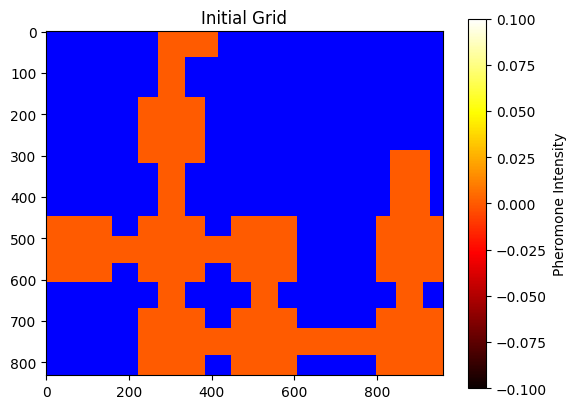

Iteration 1/50
Ant 0 reached the goal in 1204 steps.
Ant 0.0, tics: 1204, success: True
Path: [(884, 763), (886, 766), (890, 770), (891, 772), (892, 772), (891, 770), (887, 768), (884, 765), (881, 763), (876, 762), (873, 761), (870, 760), (865, 761), (864, 763), (861, 765), (859, 764), (858, 760), (857, 758), (857, 758), (859, 756), (863, 754), (870, 754), (875, 755), (877, 757), (875, 757), (873, 760), (873, 763), (876, 766), (879, 771), (879, 775), (880, 779), (880, 782), (881, 785), (882, 789), (883, 791), (887, 793), (888, 794), (886, 794), (885, 792), (884, 787), (886, 784), (886, 780), (885, 775), (883, 769), (881, 763), (878, 756), (873, 752), (872, 750), (874, 750), (875, 751), (874, 753), (870, 753), (869, 754), (869, 753), (871, 752), (873, 753), (875, 753), (878, 750), (880, 744), (883, 737), (885, 733), (887, 728), (889, 721), (891, 717), (894, 714), (895, 712), (898, 711), (903, 710), (908, 708), (912, 707), (915, 710), (916, 714), (918, 717), (917, 718), (916, 716), (913,

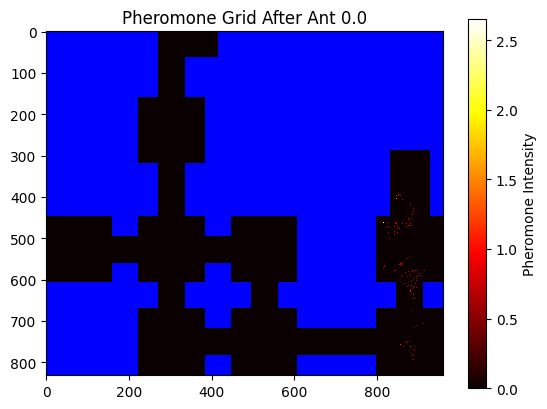

Ant 1 reached the goal in 1004 steps.
Ant 0.1, tics: 1004, success: True
Path: [(881, 765), (881, 765), (879, 764), (876, 765), (874, 765), (875, 764), (878, 765), (882, 763), (883, 760), (884, 756), (887, 752), (893, 750), (896, 747), (897, 747), (897, 750), (898, 751), (896, 751), (895, 748), (895, 743), (894, 740), (892, 741), (893, 743), (897, 745), (901, 744), (904, 746), (909, 748), (913, 752), (917, 754), (920, 753), (926, 752), (930, 753), (934, 753), (940, 752), (942, 754), (942, 755), (940, 756), (940, 757), (938, 757), (937, 755), (938, 753), (941, 752), (942, 752), (943, 751), (942, 751), (941, 754), (942, 757), (942, 760), (943, 760), (943, 760), (943, 760), (943, 759), (942, 759), (942, 761), (943, 760), (942, 761), (942, 760), (943, 757), (943, 754), (942, 754), (939, 754), (934, 753), (927, 752), (920, 752), (914, 752), (911, 748), (908, 743), (908, 738), (910, 732), (912, 725), (916, 718), (918, 713), (918, 710), (918, 706), (921, 703), (924, 703), (925, 706), (925, 71

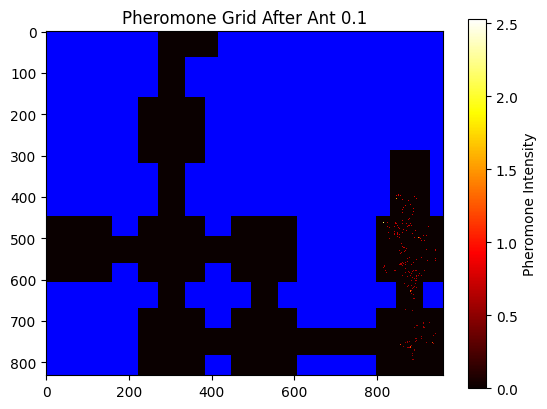

Ant 0.2, tics: 2110, success: False
Path: [(413, 758), (416, 761), (419, 766), (419, 766), (420, 767), (421, 767), (422, 765), (419, 762), (418, 758), (419, 752), (422, 748), (423, 746), (426, 747), (431, 750), (437, 754), (441, 756), (445, 758), (448, 760), (451, 762), (456, 765), (461, 767), (461, 765), (459, 762), (455, 758), (452, 753), (449, 749), (448, 745), (445, 740), (443, 735), (445, 736), (445, 736), (443, 738), (443, 738), (441, 736), (438, 735), (436, 736), (434, 737), (432, 735), (428, 735), (426, 736), (424, 736), (423, 737), (422, 740), (419, 745), (418, 748), (416, 751), (413, 756), (408, 760), (405, 764), (405, 765), (406, 767), (410, 767), (414, 767), (417, 765), (417, 765), (419, 767), (421, 765), (422, 761), (424, 760), (428, 757), (432, 752), (438, 749), (442, 749), (444, 748), (446, 748), (447, 750), (446, 754), (444, 760), (444, 767), (445, 766), (448, 763), (452, 762), (459, 762), (462, 762), (467, 762), (473, 764), (480, 765), (484, 763), (488, 760), (490, 755

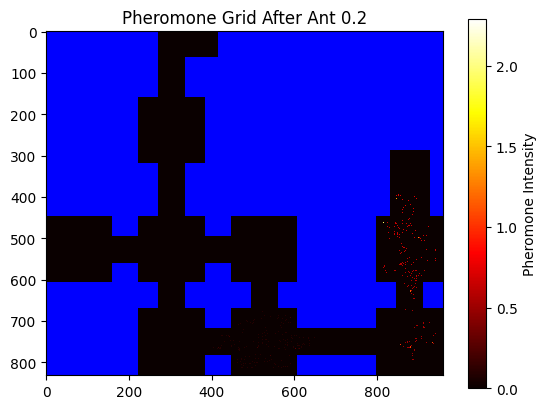

Ant 0.3, tics: 2110, success: False
Path: [(882, 761), (883, 756), (887, 752), (890, 747), (896, 743), (904, 740), (910, 740), (915, 739), (918, 736), (919, 736), (921, 737), (924, 741), (928, 745), (930, 747), (931, 747), (932, 749), (930, 750), (930, 752), (928, 752), (927, 751), (926, 751), (926, 752), (928, 751), (929, 752), (932, 754), (936, 754), (942, 753), (942, 755), (940, 756), (938, 755), (936, 751), (933, 747), (928, 742), (924, 737), (919, 733), (916, 729), (912, 725), (908, 719), (906, 711), (901, 703), (900, 697), (898, 695), (899, 694), (898, 693), (897, 694), (896, 693), (897, 693), (901, 693), (905, 695), (908, 696), (911, 694), (912, 691), (910, 687), (906, 687), (903, 689), (898, 691), (891, 691), (885, 690), (883, 688), (881, 689), (877, 690), (876, 692), (876, 691), (876, 687), (877, 681), (879, 674), (878, 667), (877, 663), (875, 658), (872, 653), (872, 649), (869, 645), (867, 640), (868, 636), (870, 630), (871, 627), (872, 623), (876, 620), (879, 619), (883, 620

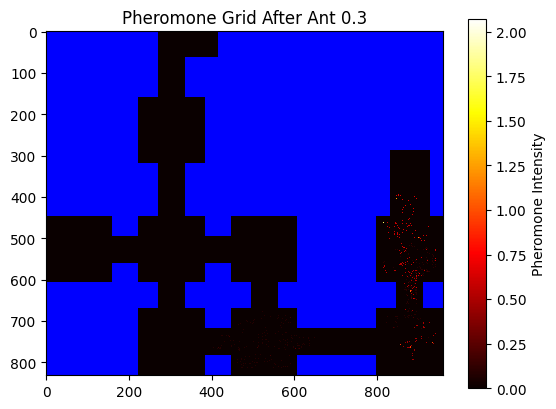

Ant 0.4, tics: 2110, success: False
Path: [(879, 762), (879, 762), (877, 762), (876, 759), (874, 758), (873, 756), (870, 753), (868, 749), (864, 744), (860, 737), (858, 729), (856, 724), (856, 721), (856, 721), (856, 724), (856, 724), (857, 722), (855, 719), (851, 716), (849, 714), (849, 710), (847, 706), (846, 702), (845, 699), (843, 695), (844, 691), (846, 687), (849, 687), (852, 690), (853, 695), (856, 700), (860, 703), (864, 702), (867, 703), (868, 706), (870, 708), (871, 710), (874, 714), (877, 719), (878, 725), (878, 734), (881, 742), (883, 751), (887, 760), (888, 766), (889, 774), (888, 782), (888, 788), (890, 793), (892, 799), (896, 805), (899, 813), (899, 814), (898, 815), (898, 812), (900, 811), (902, 811), (901, 812), (900, 810), (900, 806), (901, 800), (901, 796), (899, 794), (896, 793), (893, 796), (890, 796), (887, 795), (883, 793), (881, 787), (877, 782), (876, 778), (873, 774), (871, 769), (867, 763), (862, 760), (860, 760), (857, 758), (854, 759), (853, 761), (853, 761

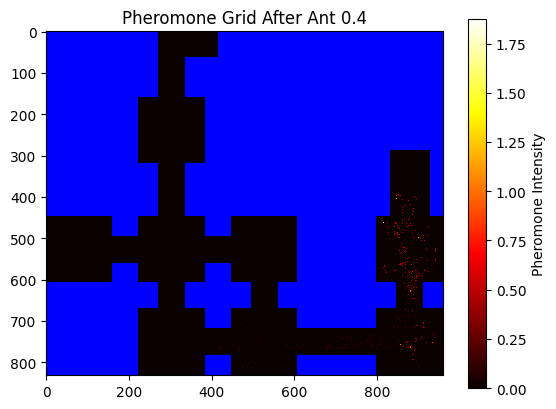

Ant 0.5, tics: 2110, success: False
Path: [(533, 759), (533, 758), (532, 757), (530, 755), (524, 755), (519, 752), (512, 750), (507, 750), (502, 749), (497, 746), (493, 744), (490, 741), (489, 738), (490, 737), (490, 735), (488, 733), (483, 732), (481, 731), (480, 732), (480, 736), (482, 739), (486, 743), (489, 750), (494, 755), (499, 762), (506, 767), (510, 772), (512, 774), (513, 773), (513, 770), (515, 765), (520, 761), (524, 756), (530, 750), (533, 746), (537, 742), (541, 740), (545, 742), (551, 744), (556, 743), (558, 742), (561, 741), (566, 739), (569, 738), (573, 737), (579, 735), (585, 736), (590, 735), (591, 734), (589, 733), (588, 732), (588, 729), (588, 724), (588, 721), (590, 719), (591, 719), (591, 722), (590, 723), (590, 725), (588, 728), (588, 730), (588, 730), (590, 728), (591, 729), (591, 729), (591, 729), (591, 728), (589, 727), (586, 725), (581, 723), (576, 719), (571, 713), (565, 709), (559, 707), (553, 706), (544, 707), (535, 708), (527, 711), (522, 714), (519, 714

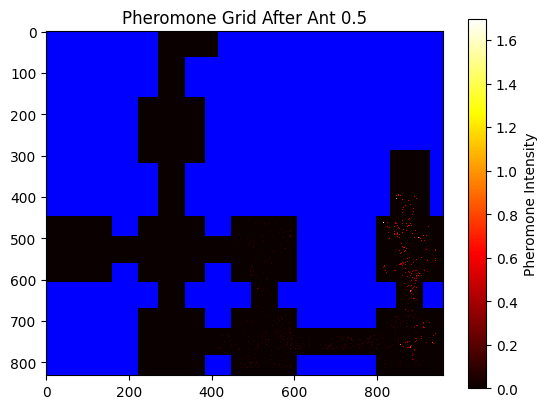

Ant 0.6, tics: 2110, success: False
Path: [(523, 640), (519, 640), (514, 642), (512, 644), (512, 644), (512, 641), (514, 638), (514, 635), (511, 633), (511, 633), (511, 632), (511, 632), (513, 633), (515, 637), (517, 642), (520, 648), (526, 653), (533, 657), (538, 660), (541, 665), (541, 670), (541, 671), (539, 672), (536, 674), (533, 679), (533, 684), (532, 688), (528, 691), (522, 693), (518, 695), (518, 697), (516, 699), (514, 702), (510, 705), (506, 706), (504, 703), (503, 700), (502, 698), (498, 696), (496, 694), (493, 693), (492, 692), (492, 688), (492, 687), (492, 689), (492, 689), (492, 687), (494, 687), (495, 687), (494, 689), (493, 694), (492, 701), (490, 707), (486, 714), (484, 719), (480, 722), (473, 724), (468, 723), (463, 722), (463, 721), (465, 720), (467, 722), (469, 722), (473, 722), (477, 719), (483, 716), (488, 716), (494, 717), (502, 718), (507, 719), (511, 722), (513, 723), (514, 722), (515, 722), (517, 725), (518, 729), (519, 736), (518, 742), (514, 747), (507, 751

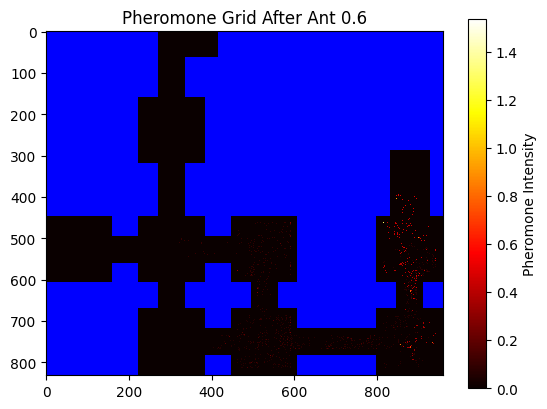

Ant 0.7, tics: 2110, success: False
Path: [(525, 527), (527, 524), (530, 521), (536, 518), (544, 514), (553, 510), (559, 507), (562, 503), (566, 501), (567, 501), (567, 503), (569, 507), (568, 512), (569, 516), (570, 517), (572, 516), (574, 513), (574, 511), (570, 509), (569, 508), (568, 504), (568, 503), (570, 502), (573, 503), (577, 504), (582, 507), (585, 510), (585, 511), (588, 511), (591, 512), (591, 512), (591, 511), (590, 508), (587, 505), (587, 502), (586, 498), (584, 491), (585, 484), (586, 477), (584, 470), (584, 464), (586, 463), (588, 465), (591, 467), (589, 468), (584, 470), (578, 472), (571, 472), (568, 471), (566, 472), (563, 474), (558, 476), (552, 476), (545, 476), (539, 478), (534, 479), (532, 478), (533, 476), (536, 474), (539, 470), (542, 468), (544, 465), (543, 463), (540, 464), (537, 463), (533, 464), (528, 463), (522, 464), (517, 463), (514, 465), (509, 468), (503, 472), (499, 474), (499, 475), (501, 475), (506, 474), (513, 473), (519, 474), (527, 475), (532, 476

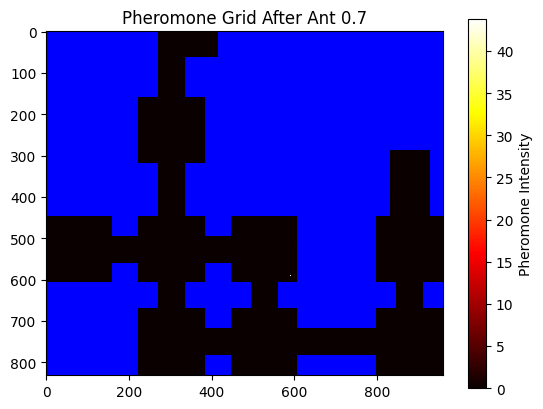

Ant 0.8, tics: 2110, success: False
Path: [(884, 762), (884, 762), (882, 763), (879, 766), (875, 769), (870, 770), (866, 767), (863, 767), (860, 765), (855, 763), (851, 764), (848, 768), (848, 771), (847, 774), (844, 774), (842, 772), (837, 769), (831, 768), (825, 769), (818, 771), (815, 773), (815, 775), (815, 777), (815, 778), (817, 778), (820, 781), (825, 783), (830, 787), (833, 788), (837, 791), (842, 794), (845, 796), (849, 798), (852, 797), (855, 798), (860, 798), (862, 799), (861, 801), (862, 802), (861, 803), (859, 801), (857, 798), (853, 794), (849, 790), (843, 785), (835, 782), (830, 780), (829, 777), (831, 774), (831, 772), (830, 769), (829, 763), (830, 757), (829, 753), (826, 749), (822, 745), (819, 742), (816, 739), (814, 738), (813, 740), (812, 739), (813, 738), (815, 739), (819, 741), (821, 742), (824, 743), (827, 745), (833, 747), (835, 750), (837, 754), (837, 758), (835, 760), (835, 763), (832, 766), (826, 770), (819, 773), (815, 775), (815, 778), (817, 779), (822, 779

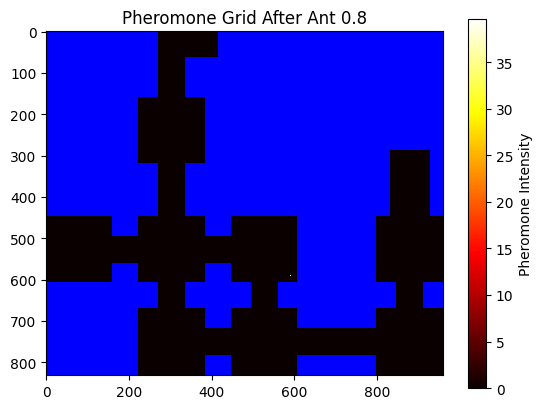

Ant 0.9, tics: 2110, success: False
Path: [(412, 530), (412, 530), (413, 528), (415, 524), (417, 522), (419, 521), (423, 519), (428, 518), (432, 519), (438, 521), (443, 521), (446, 519), (446, 517), (444, 517), (444, 516), (442, 516), (440, 519), (436, 522), (434, 524), (434, 524), (434, 526), (435, 529), (435, 530), (432, 531), (427, 530), (420, 528), (414, 525), (412, 522), (413, 520), (415, 517), (415, 514), (412, 511), (409, 511), (405, 513), (399, 515), (395, 514), (392, 511), (391, 513), (387, 515), (386, 517), (383, 518), (378, 517), (375, 518), (376, 519), (378, 518), (380, 515), (384, 511), (387, 512), (393, 513), (397, 517), (401, 519), (403, 519), (402, 517), (401, 514), (402, 512), (402, 511), (400, 513), (398, 518), (397, 520), (394, 520), (393, 521), (394, 523), (396, 527), (394, 530), (392, 534), (388, 537), (384, 538), (384, 538), (382, 538), (378, 537), (376, 537), (374, 539), (373, 539), (374, 536), (372, 533), (368, 529), (362, 525), (359, 522), (355, 519), (351, 514

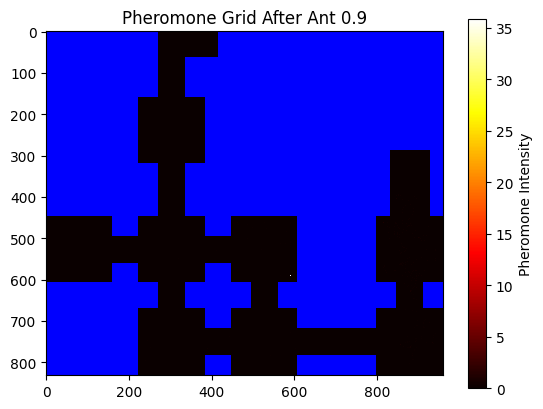

Pheromone grid image saved to aco_runs/vizdoom_aco_mywayhome\run_11\log\pheromone_grid_iteration_0.png


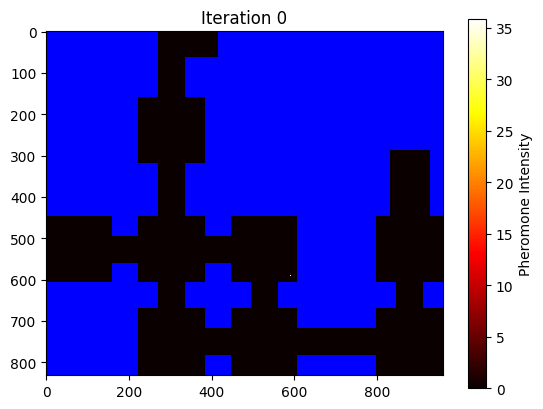

Spawn counts and success ratios:
Spawned far: 0/1
Spawned relatively close: 0/3
Spawned close: 2/6
Iteration 2/50
Ant 1.0, tics: 2110, success: False
Path: [(880, 640), (885, 639), (890, 640), (893, 639), (895, 637), (892, 637), (891, 639), (888, 642), (886, 644), (884, 646), (883, 648), (886, 648), (886, 649), (887, 651), (889, 654), (893, 658), (895, 660), (895, 662), (895, 663), (894, 662), (894, 663), (895, 666), (895, 666), (895, 665), (895, 663), (894, 659), (895, 655), (895, 655), (892, 656), (892, 657), (891, 658), (891, 658), (893, 658), (894, 656), (895, 654), (892, 654), (889, 652), (885, 650), (878, 649), (874, 648), (873, 646), (873, 643), (870, 640), (868, 639), (864, 641), (863, 643), (863, 642), (864, 640), (865, 636), (866, 630), (868, 623), (871, 620), (875, 617), (882, 614), (889, 614), (894, 613), (895, 612), (892, 612), (889, 610), (885, 608), (878, 608), (873, 610), (868, 610), (863, 607), (863, 606), (864, 609), (863, 612), (863, 617), (863, 618), (865, 617), (86

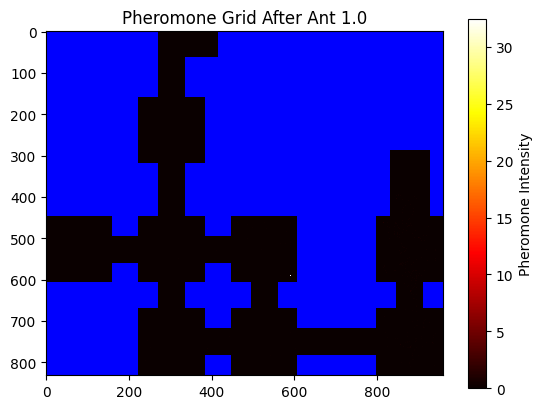

Ant 1.1, tics: 2110, success: False
Path: [(415, 533), (417, 537), (420, 543), (421, 543), (420, 543), (417, 543), (413, 541), (411, 538), (408, 536), (403, 535), (401, 534), (397, 534), (393, 532), (388, 528), (385, 526), (383, 527), (380, 529), (377, 534), (377, 540), (374, 543), (374, 542), (373, 539), (370, 537), (365, 536), (359, 534), (355, 533), (351, 532), (350, 529), (351, 525), (355, 521), (357, 518), (356, 517), (356, 516), (356, 512), (355, 506), (355, 503), (353, 502), (353, 501), (351, 500), (347, 501), (342, 500), (340, 497), (340, 497), (341, 499), (344, 501), (348, 504), (354, 506), (358, 506), (364, 504), (367, 501), (365, 500), (362, 496), (360, 495), (359, 497), (361, 498), (364, 501), (366, 502), (367, 500), (367, 499), (365, 501), (365, 501), (367, 500), (365, 501), (365, 501), (367, 500), (367, 499), (365, 499), (362, 497), (360, 497), (360, 496), (362, 498), (364, 498), (366, 496), (367, 495), (367, 497), (365, 499), (361, 503), (358, 505), (358, 508), (360, 511

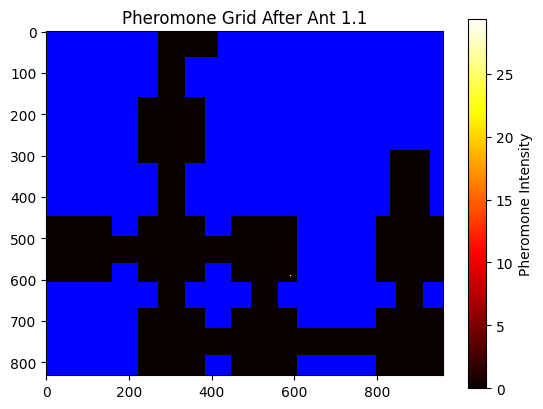

KeyboardInterrupt: 

In [41]:
#Initialize the environment and run ACO training

env = mywayhome_VZG(config_path=doomfinder("my_way_home_4_dir.cfg"), pheromone_evaporation_rate=0.000238095238, render=False, frameskip=2) #Lower frameskip makes better maps but takes longer

#Create run directory
run_dir, log_dir, maps_dir = create_run_directory()

if saved_pheromone_grid is not None:
        env.pheromone_map = saved_pheromone_grid
else:
    env.pheromone_map = get_starting_grid()
    
aco_training(env, num_ants = 10, iterations=50, pheromone_deposit = 2.0, run_dir=run_dir, log_dir=log_dir, maps_dir=maps_dir, beta=1.0) #Run ACO training

Test Pheromone Map

In [34]:
#Initialize the environment for testing
env = mywayhome_VZG(config_path=doomfinder("my_way_home_4_dir.cfg"), pheromone_evaporation_rate=0, render=True, frameskip=4) 

#Run the test function
test_saved_maps(env=env, num_tests=1, pheromone_grid=saved_pheromone_grid, alpha = 0.6, beta = 0.4) #Test the saved pheromone maps

Test 1: Did not reach the goal.
Test 1, tics: 2110, success: False
Path: [(293, 109), (287, 112), (287, 108), (287, 96), (287, 79), (294, 64), (309, 50), (321, 33), (335, 17), (338, 17), (343, 17), (347, 16), (351, 22), (347, 32), (335, 41), (329, 47), (327, 43), (323, 31), (318, 17), (316, 16), (316, 22), (311, 32), (305, 46), (309, 57), (313, 57), (313, 47), (319, 35), (329, 32), (334, 27), (330, 22), (331, 18), (341, 15), (353, 22), (369, 28), (385, 38), (399, 45), (393, 47), (386, 41), (378, 26), (365, 16), (356, 17), (349, 26), (338, 38), (334, 44), (341, 46), (348, 40), (359, 30), (376, 20), (386, 16), (381, 17), (367, 22), (356, 32), (348, 36), (340, 29), (340, 18), (340, 16), (345, 15), (353, 22), (358, 23), (362, 27), (368, 40), (378, 47), (382, 40), (385, 38), (396, 38), (399, 43), (399, 45), (395, 47), (383, 47), (370, 41), (362, 40), (356, 36), (344, 31), (335, 36), (331, 47), (325, 47), (325, 46), (329, 47), (329, 41), (326, 26), (321, 16), (321, 22), (328, 28), (338, 38),